In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import keras as ks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau




2025-01-06 13:20:20.637906: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
db_path='./triple_mnist/'

def flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            flattened_img = (Image.open(img_path))
            flattened_img = (np.array((flattened_img).convert('L')))

            imgs.append(flattened_img)
            labels.append(int(folder))
            
    return np.array(imgs), np.array(labels)


f_train_imgs, f_train_labels = flatten_toarray('train')
f_test_imgs, f_test_labels = flatten_toarray('test')
f_val_imgs, f_val_labels = flatten_toarray('val')

f_train_imgs = f_train_imgs / 255.0
f_test_imgs = f_test_imgs / 255.0
f_val_imgs = f_val_imgs / 255.0

In [6]:
db_path='./triple_mnist/'

def splits_flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            img = Image.open(img_path).convert('L').resize((45,45))
            
            width, height = img.size
            
            split_width = width // 3

            splits = [
                img.crop((i * split_width, 0, (i + 1) * split_width, height))
                for i in range(3)
            ]

            for i, split in enumerate(splits):
                imgs.append(np.array(split))  
                labels.append(int(folder[i]))

    return np.array(imgs), np.array(labels)


t_train_imgs, t_train_labels = splits_flatten_toarray('train')
t_test_imgs, t_test_labels = splits_flatten_toarray('test')
t_val_imgs, t_val_labels = splits_flatten_toarray('val')

t_train_imgs = t_train_imgs / 255.0
t_test_imgs = t_test_imgs / 255.0
t_val_imgs = t_val_imgs / 255.0

In [18]:
db_path='./triple_mnist/'

def splits_flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            img = Image.open(img_path).convert('L')
            
            width, height = img.size
            
            split_width = width // 3

            splits = [
                img.crop((i * split_width, 0, (i + 1) * split_width, height))
                for i in range(3)
            ]

            for i, split in enumerate(splits):
                imgs.append(np.array(split))  
                labels.append(int(folder[i]))

    return np.array(imgs), np.array(labels)


ft_train_imgs, ft_train_labels = splits_flatten_toarray('train')
ft_test_imgs, ft_test_labels = splits_flatten_toarray('test')
ft_val_imgs, ft_val_labels = splits_flatten_toarray('val')

ft_train_imgs = ft_train_imgs / 255.0
ft_test_imgs = ft_test_imgs / 255.0
ft_val_imgs = ft_val_imgs / 255.0

In [7]:
rs_t_train_labels = t_train_labels.reshape(64000, 3)
rs_f_train_imgs = tf.convert_to_tensor(f_train_imgs)
rs_f_train_imgs = tf.reshape(rs_f_train_imgs, (64000, 84, 84, 1))


print(rs_t_train_labels.shape)
print(rs_f_train_imgs.shape)


(64000, 3)
(64000, 84, 84, 1)


In [8]:
def build_generator():
    # Label embedding
    label_embedding = layers.Embedding(10, 16, name="label_embedding")

    # Label projection
    label_proj = layers.Dense(128 * 6 * 6, name="label_proj")

    # Noise projection
    noise_proj = layers.Dense(256 * 6 * 6, name="noise_proj")

    # Convolutional blocks remain the same
    conv_blocks = tf.keras.Sequential([
        layers.Conv2DTranspose(256, kernel_size=2, strides=7, padding='same', use_bias=False, 
                             input_shape=(384, 6, 6), data_format='channels_first'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', 
                             use_bias=False, data_format='channels_first'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', 
                             use_bias=False, data_format='channels_first'),
        layers.Activation('tanh')
    ])

    def generator(noise, labels):
        # Handle dynamic batch size using tf.shape
        batch_size = tf.shape(noise)[0]
        
        # Use tf.slice instead of Python slicing
        labels = tf.slice(labels, [0, 0], [batch_size, -1])
        
        # Embed labels
        emb1 = label_embedding(labels[:, 0])
        emb2 = label_embedding(labels[:, 1])
        emb3 = label_embedding(labels[:, 2])
        
        # Concatenate embeddings
        emb_cat = tf.concat([emb1, emb2, emb3], axis=1)
        
        # Project labels
        label_feat = label_proj(emb_cat)
        label_feat = tf.reshape(label_feat, tf.concat([[batch_size], [128, 6, 6]], axis=0))
        
        # Project noise
        noise_feat = noise_proj(noise)
        noise_feat = tf.reshape(noise_feat, tf.concat([[batch_size], [256, 6, 6]], axis=0))
        
        # Combine features
        combined = tf.concat([noise_feat, label_feat], axis=1)
        
        # Generate output
        output = conv_blocks(combined)
        output = tf.reshape(output, tf.concat([[batch_size], [84, 84, 1]], axis=0))
        
        return output

    return generator

In [9]:
def build_discriminator(dropout_rate=0.3):
    # Label embeddings
    label_embedding_1 = layers.Embedding(10, 16, name="label_embedding_1")
    label_embedding_2 = layers.Embedding(10, 16, name="label_embedding_2")
    label_embedding_3 = layers.Embedding(10, 16, name="label_embedding_3")
    
    # Label projections with controlled output size
    label_proj_blocks = [
        tf.keras.Sequential([
            layers.Dense(64, name=f"label_proj_dense_{i}"),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2)
        ], name=f"label_proj_{i}") for i in range(1, 4)
    ]
    
    # Convolutional blocks
    conv_blocks = tf.keras.Sequential([
        layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(dropout_rate),
        
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(dropout_rate),
        
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(dropout_rate),
        
        layers.Flatten()
    ], name="conv_blocks")
    
    # Output blocks
    adversarial = tf.keras.Sequential([
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation="sigmoid")
    ], name="adversarial")
    
    def discriminator(img, labels):
        # Get batch size from input image
        batch_size = tf.shape(img)[0]
        
        # Ensure labels match batch size
        labels = tf.slice(labels, [0, 0], [batch_size, -1])
        
        # Process each label embedding
        emb1 = label_embedding_1(labels[:, 0])
        emb2 = label_embedding_2(labels[:, 1])
        emb3 = label_embedding_3(labels[:, 2])
        
        # Process embeddings through projection blocks
        feat1 = label_proj_blocks[0](emb1)
        feat2 = label_proj_blocks[1](emb2)
        feat3 = label_proj_blocks[2](emb3)
        
        # Combine label features
        label_feat = tf.concat([feat1, feat2, feat3], axis=1)
        
        # Process image through conv blocks
        conv_feat = conv_blocks(img)
        
        # Ensure label_feat has the same batch size as conv_feat
        label_feat = tf.broadcast_to(label_feat, [batch_size, tf.shape(label_feat)[1]])
        
        # Combine features
        combined_features = tf.concat([conv_feat, label_feat], axis=1)
        
        # Generate validity score
        validity = adversarial(combined_features)
        
        return validity
    
    return discriminator

In [10]:
def build_gan(generator, discriminator, latent_dim):
    # Create the input tensors for the GAN
    noise_input = layers.Input(shape=(latent_dim,), name="noise_input")
    label_input = layers.Input(shape=(3,), dtype=tf.int32, name="label_input")
    
    # Generate fake images using the generator
    fake_images = generator(noise_input, label_input)
    
    # Get validity from discriminator
    validity = discriminator(fake_images, label_input)
    
    # Create the GAN model
    gan = tf.keras.Model(inputs=[noise_input, label_input], outputs=validity, name="gan_model")
    
    return gan

In [11]:
def generate_and_visualize(generator, latent_dim):
    noise = np.random.normal(0, 1, (3, latent_dim))  # Generate 3 random noise vectors
    labels = np.random.randint(0, 10, (3, 3))  # Random labels for the generated images
    generated_images = generator.predict([noise, labels])

    # Rescale images to [0, 255] for display
    generated_images = (generated_images + 1) * 127.5
    generated_images = np.clip(generated_images, 0, 255).astype(np.uint8)

    # Plot the generated images
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 3 columns
    for i in range(3):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [12]:
def train_gan(generator, discriminator, gan, train_images, train_labels, latent_dim, epochs, batch_size, display_interval=25):
    num_samples = train_images.shape[0]
    
    for epoch in range(epochs):
        # Generate batch indices
        idx = np.random.randint(0, num_samples, batch_size)
        

        # Get real images and labels
        real_images = tf.gather(train_images, idx)
        real_labels = tf.gather(train_labels, idx)
        
        # Generate noise
        noise = tf.random.normal((batch_size, latent_dim))
        
        # Generate fake images
        fake_images = generator([noise, real_labels], training=True)
        
        # Create labels for training
        real_labels_ = tf.ones((batch_size, 1))
        fake_labels_ = tf.zeros((batch_size, 1))
        
        # Train discriminator
        with tf.GradientTape() as tape:
            # Real images
            real_validity = discriminator([real_images, real_labels], training=True)
            d_loss_real = tf.keras.losses.binary_crossentropy(real_labels_, real_validity)
            
            # Fake images
            fake_validity = discriminator([fake_images, real_labels], training=True)
            d_loss_fake = tf.keras.losses.binary_crossentropy(fake_labels_, fake_validity)
            
            # Total discriminator loss
            d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)
        
        # Apply discriminator gradients
        d_grads = tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator.optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))
        
        # Train generator
        noise = tf.random.normal((batch_size, latent_dim))
        with tf.GradientTape() as tape:
            # Generate images
            gen_images = generator([noise, real_labels], training=True)
            # Get discriminator output
            fake_validity = discriminator([gen_images, real_labels], training=True)
            # Calculate generator loss
            g_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(real_labels_, fake_validity)
            )
        
        # Apply generator gradients
        g_grads = tape.gradient(g_loss, generator.trainable_variables)
        generator.optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))
        
        print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

        if (epoch + 1) % display_interval == 0:
            # print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")
            generate_and_visualize(generator, latent_dim)


Epoch 1/250 - D Loss: 1.6281, G Loss: 0.6881
Epoch 2/250 - D Loss: 1.5412, G Loss: 0.6301
Epoch 3/250 - D Loss: 1.7456, G Loss: 0.6258
Epoch 4/250 - D Loss: 1.7624, G Loss: 0.7244
Epoch 5/250 - D Loss: 1.6773, G Loss: 0.6649
Epoch 6/250 - D Loss: 1.6792, G Loss: 0.6759
Epoch 7/250 - D Loss: 1.6630, G Loss: 0.6996
Epoch 8/250 - D Loss: 1.6400, G Loss: 0.7893
Epoch 9/250 - D Loss: 1.6130, G Loss: 0.7556
Epoch 10/250 - D Loss: 1.7620, G Loss: 0.8078
Epoch 11/250 - D Loss: 1.5161, G Loss: 0.8027
Epoch 12/250 - D Loss: 1.7283, G Loss: 0.6906
Epoch 13/250 - D Loss: 1.7845, G Loss: 0.7264
Epoch 14/250 - D Loss: 1.6672, G Loss: 0.6795
Epoch 15/250 - D Loss: 1.8100, G Loss: 0.7900
Epoch 16/250 - D Loss: 1.6718, G Loss: 0.7365
Epoch 17/250 - D Loss: 1.6621, G Loss: 0.6712
Epoch 18/250 - D Loss: 1.5616, G Loss: 0.7253
Epoch 19/250 - D Loss: 1.6687, G Loss: 0.7192
Epoch 20/250 - D Loss: 1.7338, G Loss: 0.6695
Epoch 21/250 - D Loss: 1.6258, G Loss: 0.7330
Epoch 22/250 - D Loss: 1.6295, G Loss: 0.75

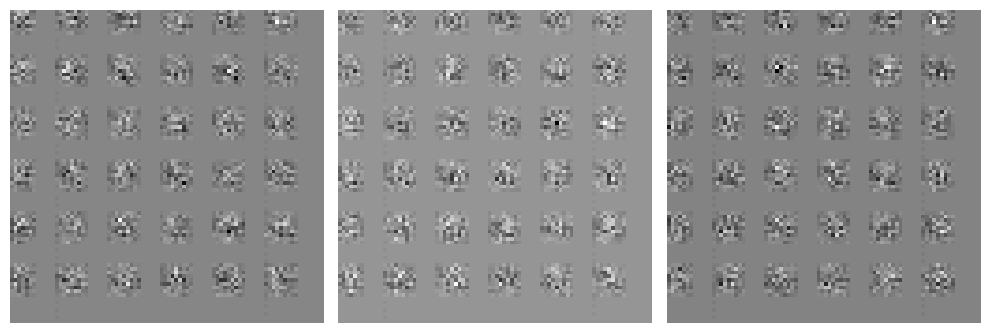

Epoch 51/250 - D Loss: 1.6362, G Loss: 0.7554
Epoch 52/250 - D Loss: 1.6799, G Loss: 0.7798
Epoch 53/250 - D Loss: 1.6064, G Loss: 0.7768
Epoch 54/250 - D Loss: 1.5238, G Loss: 0.8273
Epoch 55/250 - D Loss: 1.6215, G Loss: 0.7662
Epoch 56/250 - D Loss: 1.5605, G Loss: 0.7972
Epoch 57/250 - D Loss: 1.5304, G Loss: 0.7500
Epoch 58/250 - D Loss: 1.5625, G Loss: 0.7523
Epoch 59/250 - D Loss: 1.6191, G Loss: 0.7554
Epoch 60/250 - D Loss: 1.6019, G Loss: 0.7736
Epoch 61/250 - D Loss: 1.5763, G Loss: 0.8098
Epoch 62/250 - D Loss: 1.5627, G Loss: 0.7307
Epoch 63/250 - D Loss: 1.6255, G Loss: 0.8434
Epoch 64/250 - D Loss: 1.5589, G Loss: 0.7312
Epoch 65/250 - D Loss: 1.4976, G Loss: 0.7960
Epoch 66/250 - D Loss: 1.5369, G Loss: 0.7253
Epoch 67/250 - D Loss: 1.5365, G Loss: 0.8645
Epoch 68/250 - D Loss: 1.5900, G Loss: 0.8519
Epoch 69/250 - D Loss: 1.6556, G Loss: 0.7924
Epoch 70/250 - D Loss: 1.6024, G Loss: 0.8262
Epoch 71/250 - D Loss: 1.6004, G Loss: 0.7324
Epoch 72/250 - D Loss: 1.5128, G L

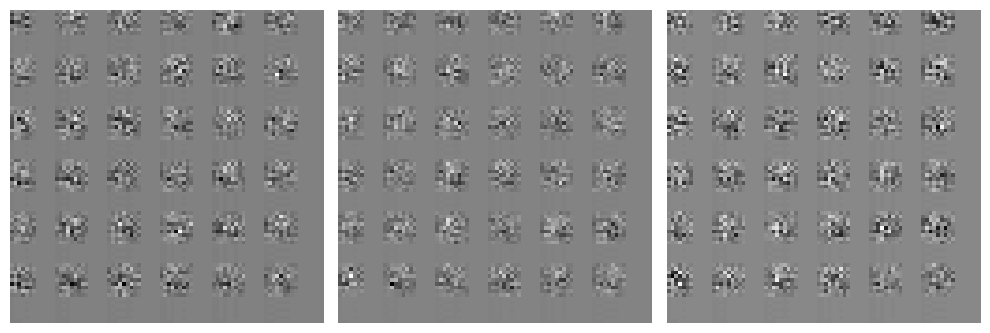

Epoch 101/250 - D Loss: 1.5029, G Loss: 0.8370
Epoch 102/250 - D Loss: 1.6148, G Loss: 0.8068
Epoch 103/250 - D Loss: 1.5581, G Loss: 0.7845
Epoch 104/250 - D Loss: 1.5610, G Loss: 0.7968
Epoch 105/250 - D Loss: 1.5547, G Loss: 0.8072
Epoch 106/250 - D Loss: 1.4825, G Loss: 0.7559
Epoch 107/250 - D Loss: 1.5455, G Loss: 0.7912
Epoch 108/250 - D Loss: 1.5122, G Loss: 0.8649
Epoch 109/250 - D Loss: 1.5102, G Loss: 0.8083
Epoch 110/250 - D Loss: 1.5689, G Loss: 0.8353
Epoch 111/250 - D Loss: 1.5167, G Loss: 0.8955
Epoch 112/250 - D Loss: 1.5946, G Loss: 0.6933
Epoch 113/250 - D Loss: 1.6025, G Loss: 0.8271
Epoch 114/250 - D Loss: 1.5516, G Loss: 0.7524
Epoch 115/250 - D Loss: 1.6122, G Loss: 0.7541
Epoch 116/250 - D Loss: 1.5678, G Loss: 0.7691
Epoch 117/250 - D Loss: 1.5845, G Loss: 0.7815
Epoch 118/250 - D Loss: 1.5905, G Loss: 0.7773
Epoch 119/250 - D Loss: 1.5012, G Loss: 0.7727
Epoch 120/250 - D Loss: 1.4700, G Loss: 0.7510
Epoch 121/250 - D Loss: 1.5190, G Loss: 0.6873
Epoch 122/250

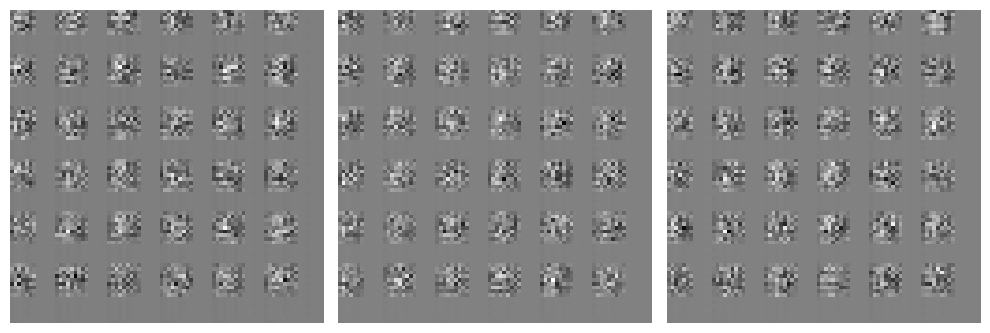

Epoch 151/250 - D Loss: 1.5528, G Loss: 0.8288
Epoch 152/250 - D Loss: 1.5786, G Loss: 0.8320
Epoch 153/250 - D Loss: 1.6773, G Loss: 0.7561
Epoch 154/250 - D Loss: 1.6112, G Loss: 0.8391
Epoch 155/250 - D Loss: 1.5191, G Loss: 0.7415
Epoch 156/250 - D Loss: 1.5049, G Loss: 0.7460
Epoch 157/250 - D Loss: 1.4213, G Loss: 0.7632
Epoch 158/250 - D Loss: 1.5201, G Loss: 0.7532
Epoch 159/250 - D Loss: 1.5598, G Loss: 0.7925
Epoch 160/250 - D Loss: 1.5702, G Loss: 0.8804
Epoch 161/250 - D Loss: 1.6115, G Loss: 0.8514
Epoch 162/250 - D Loss: 1.5321, G Loss: 0.7706
Epoch 163/250 - D Loss: 1.5069, G Loss: 0.7524
Epoch 164/250 - D Loss: 1.5091, G Loss: 0.7723
Epoch 165/250 - D Loss: 1.6466, G Loss: 0.8493
Epoch 166/250 - D Loss: 1.5140, G Loss: 0.7700
Epoch 167/250 - D Loss: 1.6034, G Loss: 0.8131
Epoch 168/250 - D Loss: 1.5074, G Loss: 0.7992
Epoch 169/250 - D Loss: 1.4375, G Loss: 0.8278
Epoch 170/250 - D Loss: 1.5227, G Loss: 0.7565
Epoch 171/250 - D Loss: 1.5300, G Loss: 0.7404
Epoch 172/250

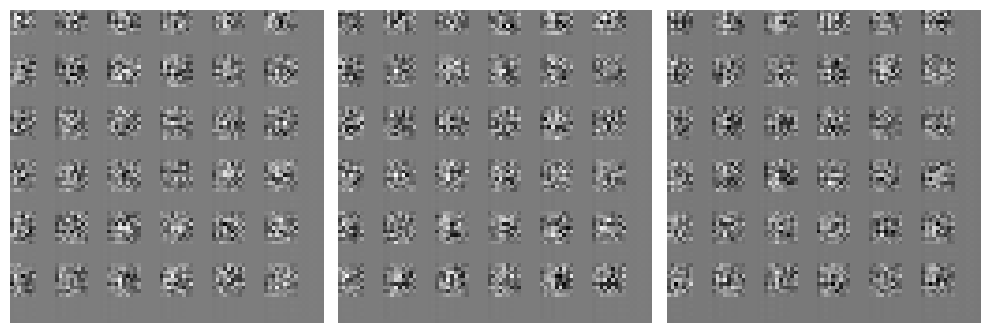

Epoch 201/250 - D Loss: 1.5417, G Loss: 0.8041
Epoch 202/250 - D Loss: 1.5837, G Loss: 0.8772
Epoch 203/250 - D Loss: 1.5054, G Loss: 0.7469
Epoch 204/250 - D Loss: 1.4058, G Loss: 0.8173
Epoch 205/250 - D Loss: 1.4850, G Loss: 0.8452
Epoch 206/250 - D Loss: 1.5472, G Loss: 0.7924
Epoch 207/250 - D Loss: 1.5111, G Loss: 0.8343
Epoch 208/250 - D Loss: 1.5017, G Loss: 0.7770
Epoch 209/250 - D Loss: 1.5164, G Loss: 0.7320
Epoch 210/250 - D Loss: 1.5307, G Loss: 0.8101
Epoch 211/250 - D Loss: 1.4668, G Loss: 0.7666
Epoch 212/250 - D Loss: 1.3940, G Loss: 0.7291
Epoch 213/250 - D Loss: 1.5014, G Loss: 0.8422
Epoch 214/250 - D Loss: 1.4129, G Loss: 0.8597
Epoch 215/250 - D Loss: 1.4162, G Loss: 0.7783
Epoch 216/250 - D Loss: 1.4888, G Loss: 0.8347
Epoch 217/250 - D Loss: 1.5005, G Loss: 0.7619
Epoch 218/250 - D Loss: 1.4889, G Loss: 0.8525
Epoch 219/250 - D Loss: 1.4533, G Loss: 0.7887
Epoch 220/250 - D Loss: 1.4839, G Loss: 0.7737
Epoch 221/250 - D Loss: 1.4377, G Loss: 0.7737
Epoch 222/250

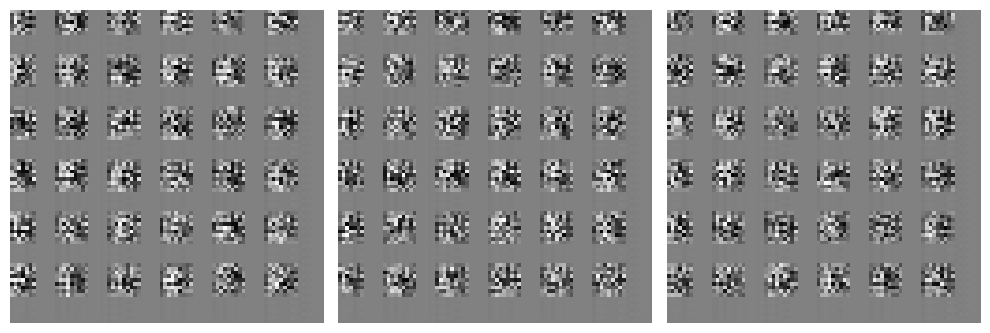

In [13]:
latent_dim = 128  # Size of the noise vector
batch_size = 64
epochs = 250
display_interval = 50

noise = np.random.normal(0, 1, (batch_size, latent_dim))
label_input = rs_t_train_labels
image_input = f_train_imgs

input_noise = tf.keras.Input(shape=(latent_dim,), name="noise_input")
input_labels = tf.keras.Input(shape=(3,), name="label_input")
input_imgs = tf.keras.Input(shape=(84, 84, 1), name="image_input")


# Define the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Build the GAN
gan = build_gan(generator, discriminator, latent_dim)

# Compile the GAN
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

fake_imgs = generator(input_noise, label_input)
validity = discriminator(input_imgs, label_input)

# Generate the model by calling the function
generator_model = tf.keras.Model(inputs=[input_noise, input_labels], outputs=fake_imgs, name="generator")
discriminator_model = tf.keras.Model(inputs=[input_imgs, input_labels], outputs=[validity], name="discriminator")

generator_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
discriminator_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the GAN
train_gan(generator_model, discriminator_model, gan, image_input, label_input, latent_dim, epochs, batch_size, display_interval)

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

def make_generator(latent_dim, num_classes):
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,))
    
    label_embedding = layers.Embedding(num_classes, latent_dim)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    
    combined_input = layers.Concatenate()([noise_input, label_embedding])
    
    x = layers.Dense(84 * 28 * 64)(combined_input)
    x = layers.Reshape((84, 28, 64))(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(1, (3, 3), padding='same', activation='tanh')(x)
    
    return models.Model([noise_input, label_input], x)

def make_discriminator(input_shape, num_classes):
    image_input = layers.Input(shape=input_shape)
    label_input = layers.Input(shape=(1,))
    
    # Process label
    label_embedding = layers.Embedding(num_classes, 84*28)(label_input)
    label_embedding = layers.Dense(84*28)(label_embedding)
    label_embedding = layers.Reshape((84, 28, 1))(label_embedding)
    
    # Process image
    combined = layers.Concatenate(axis=-1)([image_input, label_embedding])
    
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(combined)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model([image_input, label_input], x)

class CDCGAN:
    def __init__(self, input_shape=(84, 28, 1), latent_dim=100, num_classes=10):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        self.generator = make_generator(latent_dim, num_classes)
        self.discriminator = make_discriminator(input_shape, num_classes)
        
        self.generator.compile()
        self.discriminator.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Combined model
        self.discriminator.trainable = False
        noise_input = layers.Input(shape=(latent_dim,))
        label_input = layers.Input(shape=(1,))
        generated_image = self.generator([noise_input, label_input])
        validity = self.discriminator([generated_image, label_input])
        
        self.combined = models.Model([noise_input, label_input], validity)
        self.combined.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy'
        )

    def train_step(self, real_images, labels, batch_size):
        # Prepare real images
        real_batch = real_images[np.random.randint(0, real_images.shape[0], batch_size)]
        real_batch = real_batch.reshape((-1, 84, 28, 1))
        labels_batch = labels[np.random.randint(0, labels.shape[0], batch_size)]
        
        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        generated_images = self.generator.predict([noise, labels_batch], verbose=0)
        
        # Train discriminator
        d_loss_real = self.discriminator.train_on_batch(
            [real_batch, labels_batch], 
            np.ones((batch_size, 1))
        )
        d_loss_fake = self.discriminator.train_on_batch(
            [generated_images, labels_batch], 
            np.zeros((batch_size, 1))
        )
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        g_loss = self.combined.train_on_batch(
            [noise, labels_batch], 
            np.ones((batch_size, 1))
        )
        
        return d_loss[0], g_loss

In [38]:
# Initialize model
cgan = CDCGAN(input_shape=(84, 28, 1))

# Training loop (assuming you have data)
batch_size = 32
for epoch in range(50):
    d_loss, g_loss = cgan.train_step(ft_train_imgs, ft_train_labels, batch_size)